# Formula One Racing Analysis

From kaggle:

"Formula One (also Formula 1 or F1 and officially the FIA Formula One World Championship) is the highest class of single-seat auto racing that is sanctioned by the Fédération Internationale de l'Automobile (FIA). The FIA Formula One World Championship has been one of the premier forms of racing around the world since its inaugural season in 1950."

In this report, we will be directly analyzing the data starting from 1950, all the way to 2024. The data we will be examining consists of constructors, race drivers, lap times, pit stops and more.

For a more streamlined analysis, we will be focusing on four key questions.

- What is the fastest lap time for each race?
- How many of each status type occurred?
- What is the average gap between first and second place in races?
- How does the number of pit stops affect race results?

Data source: https://www.kaggle.com/datasets/jtrotman/formula-1-race-data

First, we will prepare the necessary datasets. We will start with the results dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)


# Save the datasets as variables
races_df = pd.read_csv("data/races.csv")
results_df = pd.read_csv("data/results.csv")

# Merge date and name columns
races_df['date and name'] = races_df['date'] + ' ' + races_df['name']

# Create a 'seconds' column from the milliseconds column
results_df["milliseconds"] = results_df["milliseconds"].replace("\\N", np.nan)
results_df["milliseconds"] = pd.to_numeric(results_df["milliseconds"], errors='coerce')  # Convert to numbers
results_df['seconds'] = results_df['milliseconds'] / 1000

# Convert the rank to int
results_df["rank"] = results_df["rank"].replace("\\N", np.nan)  # Replace "\N" properly
results_df["rank"] = pd.to_numeric(results_df["rank"], errors='coerce')  # Convert to numbers
results_df["rank"] = results_df["rank"].fillna(0).astype(int)  # Convert to int, replacing NaN

# Convert the position to int
results_df["position"] = results_df["position"].replace("\\N", np.nan)  # Replace "\N" properly
results_df["position"] = pd.to_numeric(results_df["position"], errors='coerce')  # Convert to numbers
results_df["position"] = results_df["position"].fillna(0).astype(int)  # Convert to int, replacing NaN

# Create a time difference column from the time column
results_df["timeDifference"] = results_df["time"].map(lambda x: x.lstrip('+'))
results_df["timeDifference"] = pd.to_numeric(results_df["timeDifference"], errors='coerce')
results_df["timeDifference"] = results_df["timeDifference"].fillna(0).astype(float)  # Convert to float, replacing NaN

# Convert the fastest lap time to a string
results_df['fastestLapTime'] = results_df['fastestLapTime'].astype(str)

# Create a "completion_status" column that determines whether the racer finished or not
results_df["completionStatus"] = results_df["statusId"].apply(lambda x: 1 if x == 1 else 0)

# Convert time to seconds
def time_to_seconds(time_str): # The parameter needs to be a string since the time format is not recognized in Python
    if pd.isna(time_str) or not isinstance(time_str, str): # if the value is NA or is not a string, return None
        return None  # Handle missing values gracefully
    if ":" not in time_str: # If the value does not have a semicolon, return None
        return None  # Handle invalid format
    minutes, rest = time_str.split(":") # Split time_str into two parts, minutes, and seconds.milliseconds
    seconds = float(rest) # Convert the seconds to a float value
    return int(minutes) * 60 + seconds  # Convert to total seconds by adding the minutes in value of seconds, and seconds

# Convert lap time to total seconds
results_df['fastestLapTimeSeconds'] = results_df['fastestLapTime'].apply(time_to_seconds)

The kaggle website included numerous datasets available to review. For the sake of being concise, we will look at only the datasets we wish to analyze.

In [2]:
results_df.describe

<bound method NDFrame.describe of        resultId  raceId  driverId  constructorId number  grid  position  \
0             1      18         1              1     22     1         1   
1             2      18         2              2      3     5         2   
2             3      18         3              3      7     7         3   
3             4      18         4              4      5    11         4   
4             5      18         5              1     23     3         5   
...         ...     ...       ...            ...    ...   ...       ...   
26754     26760    1144       825            210     20    14        16   
26755     26761    1144       859            215     30    12        17   
26756     26762    1144       822             15     77     9         0   
26757     26763    1144       861              3     43    20         0   
26758     26764    1144       815              9     11    10         0   

      positionText  positionOrder  points  ...  milliseconds fast

To analyze the fastest lap time for each race, we will need to create a separate dataset from the results dataset, filtering out only the fastest lap times.

In [3]:
# Remove rows where fastestLapTimeSeconds is Nan, group by race ID and find the lowest lap time for each corresponding race ID, then use idxmin to extract
# the corresponding rows.
valid_fastest_per_race = results_df.dropna(subset=['fastestLapTimeSeconds']).loc[
    results_df.dropna(subset=['fastestLapTimeSeconds']).groupby('raceId')['fastestLapTimeSeconds'].idxmin()
]

# Step 2: Find raceIds where all values are NaN
races_with_nan_only = results_df[results_df['raceId'].isin(results_df[results_df['fastestLapTimeSeconds'].isna()]['raceId'])]

# Step 3: Combine both results
final_df = pd.concat([valid_fastest_per_race, races_with_nan_only]).drop_duplicates(subset=['raceId'])

# Reset index for clean output
final_df = final_df.reset_index(drop=True)
races_df = races_df.merge(final_df[['raceId', 'fastestLapTimeSeconds']], on="raceId", how="left")

# Rename fastestLapTimeSeconds_x to fastestLapTimeSeconds
races_df.rename(columns={'fastestLapTimeSeconds_x': 'fastestLapTimeSeconds'}, inplace=True)

# Convert raceId to string to make it categorical
races_df["raceId"] = races_df["raceId"].astype(str)  

# Remove all rows where fastestLapTimeSeconds is empty.
races_df = races_df.dropna(subset=['fastestLapTimeSeconds'])

# Save the file to csv to read later
races_df.to_csv("output/races.csv", index=False)

Now we can plot this data using a scatterplot.

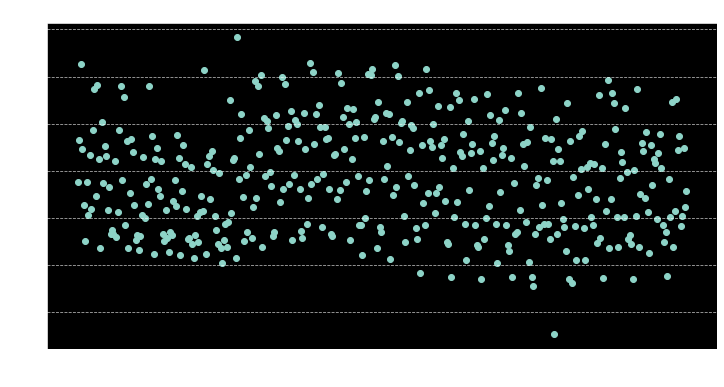

In [4]:
# Set fig size
plt.figure(figsize=(12, 6))

# Set style
plt.style.use('dark_background')

# Create the bar plot
plt.scatter(races_df["raceId"], races_df["fastestLapTimeSeconds"])

# Labels and title
plt.xlabel("Race ID")  
plt.ylabel("Fastest Lap Time (seconds)")
plt.title("Fastest Lap Time per Race")

# Improve readability
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add grid lines for better visibility
plt.xticks(np.arange(0, len(races_df["raceId"]), step=30))

# Show the plot
plt.show()

We can tell from this chart that despite the high level of variance in lap times, aside from a few outliers, the fastest lap time is constrained to a specific amount of time. We can infer this is due to the track in which the race took place on, as each track would undoubtedly differ in both length and shape. These aspects would certainly affect how fast one would be able to complete a lap.

Furthermore, track regulations likely exist which determine the length of a racetrack. Since all of these datapoints fall within a certain threshhold, it is natural to infer that each race track has around the same length, likely to account for racing logistics such as the area required for a pitstop, and extra space for emergency personnel to conduct their operations should an accident occur.

Let us now analyze the status of each racer in the results dataset.

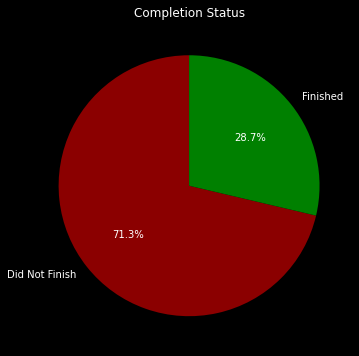

In [5]:
# Set fig size
plt.figure(figsize=(10, 6))

# Create the pie chart
plt.title("Completion Status")
plt.pie(results_df["completionStatus"].value_counts(), 
        labels=["Did Not Finish", "Finished"],
        autopct="%1.1f%%",
        startangle=90,
        colors=["darkred", "green"])

# Display the plot
plt.show()

Here we can see the majority of F1 racers do not finish. It's worth noting that those in the DNF category have a variety of status IDs indicating why they did not finish, with 1 being the only scenario where they do finish. We will now perform an analysis on the racers who did not finish.

We will do this by first merging the datasets, then creating a bar plot.

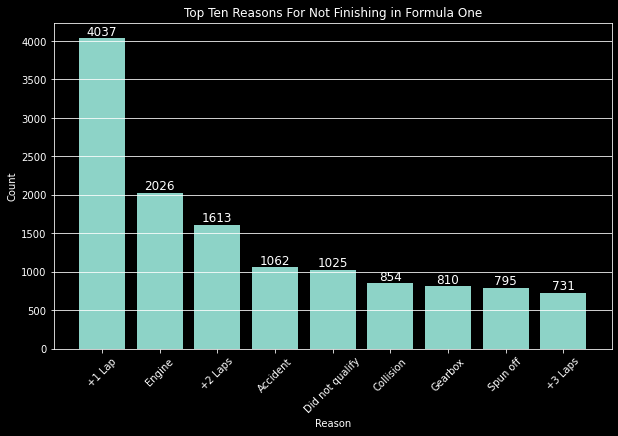

In [6]:
status_df = pd.DataFrame(results_df["statusId"].value_counts().sort_index())
status_df = status_df.rename(columns={"statusId": 'count'})
status_df.index.names = ["statusId"]
status_df = status_df.merge(pd.read_csv("data/status.csv"), on='statusId', how="left")
status_df = status_df.sort_values(by="count", ascending=False)
status_df.to_csv("output/status_df.csv")

# Set figure size
plt.figure(figsize=(10, 6))

# Create the plot
bars = plt.bar((status_df.head(10)["status"])[1:],
       (status_df.sort_values(by="count", ascending=False).head(10)["count"])[1:])
plt.title("Top Ten Reasons For Not Finishing in Formula One")
plt.xlabel("Reason")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,  # X position
             bar.get_height(),  # Y position
             f'{bar.get_height()}',  # Text (value)
             ha='center', va='bottom', fontsize=12, color='white')  # Styling


plt.show()

This plot represents all the results where the racer did not finish. Here we can establish that a large portion of racers did not finish due to being behind one to three laps. While the maximum number of laps a racer can fall behind is dependent on each race, we can safely assume there is a minimum threshold regarding the total number of laps. In the top ten DNF categories, most appear to be related to car mechanics or are accidental, with a small portion of them not qualifying.

We can use a pie chart to observe the proportion of top ten DNF categories, compared to the hundred more categories included with the status dataset.

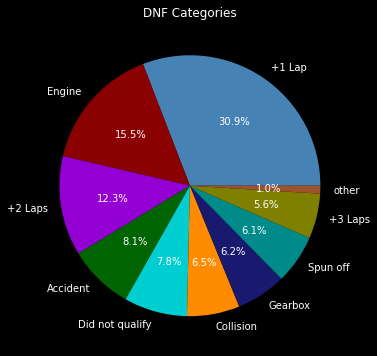

26455

In [7]:
# Create a column where every other category aside from the top ten DNF categories is listed as other
status_df["topTenStatus"] = (status_df["status"].apply(lambda x: x if status_df["status"][0:10].eq(x).any() else "other"))
status_df.loc[21, "count"] = (status_df["topTenStatus"] == "other").sum()


# Set fig size
plt.figure(figsize=(10, 6))

# Create the pie chart
plt.pie(status_df["count"][1:11], labels=status_df["topTenStatus"][1:11], autopct='%1.1f%%', 
        colors=["steelblue", "darkred", "darkviolet", "darkgreen", "darkturquoise", "darkorange", "midnightblue", "darkcyan", "olive", "sienna"])
plt.title("DNF Categories")
plt.show()

status_df["count"].sum()

Here we can see the overwhelming disparity between the top ten DNF categories, and every other category listed within the status dataset. Keep in mind there are 137 statuses total, and yet despite this, every other category aside from the top ten consists of less than one percent of the total DNF categories.

There exists a myriad of other mechanical failures within the other DNF categories, none of which are nearly as prominent. In fact, despite many of these other categories being purely mechanical, some of them have occurred less than ten times throughout all the Formula One races. Given the entertainment-based importance the F1 series has, it's likely that the vehicles are expressly engineered to minimize these mechanical failures, both for the integrity of the F1 races and for the safety of the drivers.

Let us now move on to the time difference between first and second place.

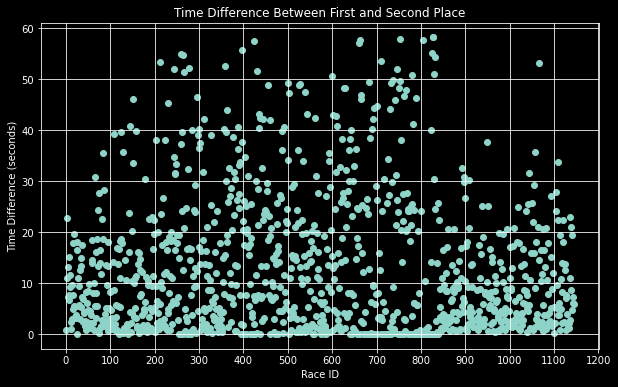

In [8]:
plt.figure(figsize=(10, 6))

plt.scatter(results_df[results_df["position"] == 2]["raceId"],
           results_df[results_df["position"] == 2]["timeDifference"])
plt.xticks(np.arange(0, len(results_df[results_df["position"] == 2]) + 100, 100))
plt.title("Time Difference Between First and Second Place")
plt.xlabel("Race ID")
plt.ylabel("Time Difference (seconds)")
plt.grid()
plt.show()

It's easy to see here that the majority of time differences between first and second place tend to be short, with a notable spread taking place across the grid. This is to be expected, as the first and second place racers would be incredibly close to outracing the other. While there are some instances where second place takes noticeably longer to finish, the presence of some outliers in this case would not invalidate the overall analysis, and there would, in fact, be some instances of second place taking more time to finish.

For a closer look at the time difference between each racer, we can look at all of the racers participating in each race.

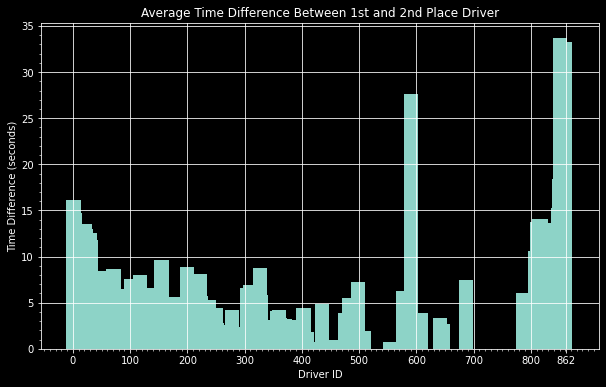

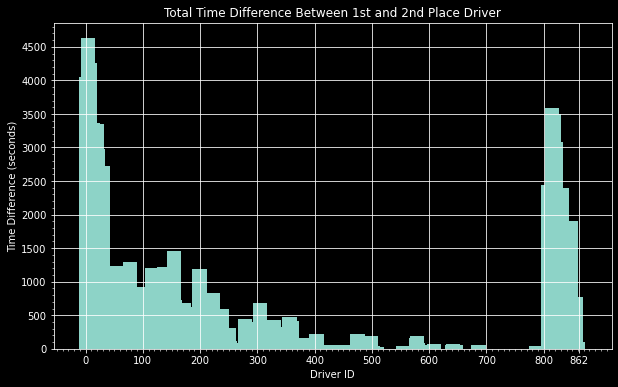

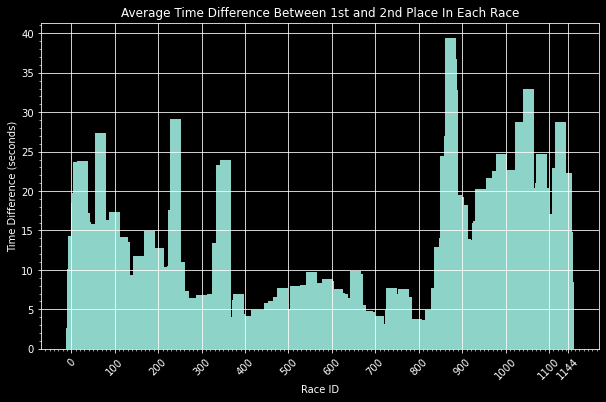

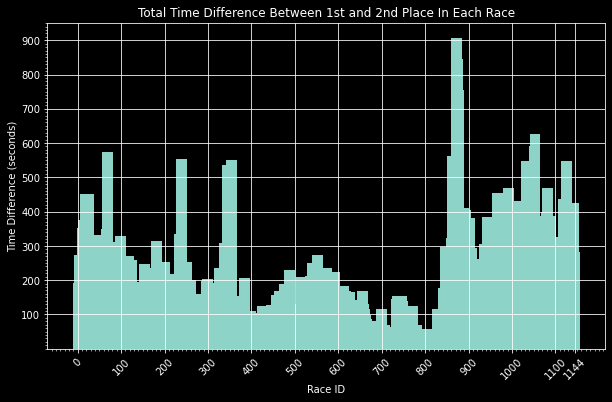

In [9]:
driver_mean_time_difference_df = results_df[results_df["position"] != 1].groupby("driverId").mean().sort_values(by=["timeDifference"])
driver_total_time_difference_df = results_df[results_df["position"] != 1].groupby("driverId").sum()
race_mean_time_difference_df = results_df[results_df["position"] != 1].groupby("raceId").mean()
race_total_time_difference_df = results_df[results_df["position"] != 1].groupby("raceId").sum()

# Create bar plot for mean time difference for each driver
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
plt.bar(driver_mean_time_difference_df.index, driver_mean_time_difference_df["timeDifference"], width=25)

# Add labels
plt.title("Average Time Difference Between 1st and 2nd Place Driver")
plt.xlabel("Driver ID")
plt.ylabel("Time Difference (seconds)")
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 862])
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
plt.grid()
plt.show()

# Create bar plot for total time difference for each driver
plt.figure(figsize=(10, 6))
plt.bar(driver_total_time_difference_df.index, driver_total_time_difference_df["timeDifference"], width=25)

# Add labels
plt.title("Total Time Difference Between 1st and 2nd Place Driver")
plt.xlabel("Driver ID")
plt.ylabel("Time Difference (seconds)")
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 862])
plt.yticks(np.arange(0, 5000, 500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(100))
plt.grid()
plt.show()

# Create bar plot for mean time difference for each race
plt.figure(figsize=(10, 6))
plt.bar(race_mean_time_difference_df.index, race_mean_time_difference_df["timeDifference"], width=25)

# Add labels
plt.title("Average Time Difference Between 1st and 2nd Place In Each Race")
plt.xlabel("Race ID")
plt.ylabel("Time Difference (seconds)")
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1144], rotation = 45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
plt.grid()
plt.show()

# Create bar plot for total time difference for each race
plt.figure(figsize=(10, 6))
plt.bar(race_total_time_difference_df.index, race_total_time_difference_df["timeDifference"], width=25)

# Add labels
plt.title("Total Time Difference Between 1st and 2nd Place In Each Race")
plt.xlabel("Race ID")
plt.ylabel("Time Difference (seconds)")
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1144], rotation = 45)
plt.yticks([100, 200, 300, 400, 500, 600, 700, 800, 900])
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(10))
plt.grid()
plt.show()

Here we can see that when grouped by race ID, the data tells a more consistent story. The third and fourth plot have no gaps whatsoever, and we can attribute this to not every driver being able to attend every racer. This would undoubtedly affect the data, and if we are to examine the trends in the first two plots, we should look at the paricipation rate of each driver.

     driverId  count
0           4    404
1           1    356
2           8    352
3          22    326
4          18    309
..        ...    ...
856       367      1
857       524      1
858       366      1
859       355      1
860       862      1

[861 rows x 2 columns]


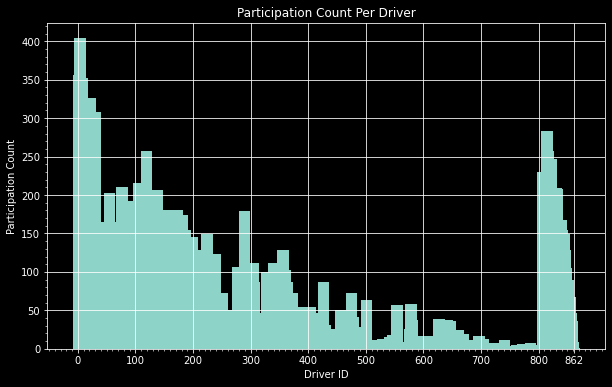

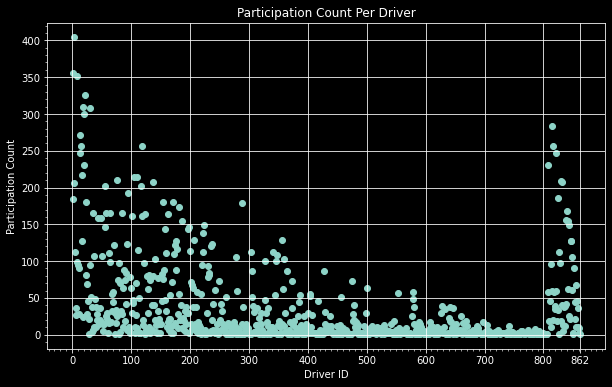

In [10]:
driver_participation_df = pd.DataFrame(results_df["driverId"].value_counts().sort_values(ascending=False).reset_index())
driver_participation_df.columns = ["driverId", "count"]
print(driver_participation_df)

# Set figsize
plt.figure(figsize=(10, 6))

# Create the plot
plt.bar(driver_participation_df["driverId"], driver_participation_df["count"], width=20)
plt.title("Participation Count Per Driver")
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 862])
plt.xlabel("Driver ID")
plt.ylabel("Participation Count")
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(10))
plt.grid()
plt.show()

# Set figsize
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(driver_participation_df["driverId"], driver_participation_df["count"])
plt.title("Participation Count Per Driver")
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 862])
plt.xlabel("Driver ID")
plt.ylabel("Participation Count")
plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(10))
plt.grid()
plt.show()

Here we can see a significant spread in the data, where some drivers only went to a handful of races, whereas others participated in up to 400. Keep in mind that the race dataset includes 1,144 races total, meaning that the maximum number of races a driver participated in is around 400. We can attribute this to a myriad of reasons, such as qualifications, location of the race, and the fact that not every driver can participate in every race. For a more consistent data analysis, we can avoid these pitfalls by analyzing each individual race specifically, while focusing on each person's individual driver's circumstances and logistics separately.